# Behavioral analysis

In this notebook we run a various analyses around the behavioral data collected during the simulation (responses to intitial survey and actions during the simulations). This includes the calculation of assortativty with respect to these features.

In [1]:
import os
from os import path
import pickle
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import networkx as nx

from utils.plotting import color_graph_by_attribute
from utils.assortativity import calc_weighted_attrib_assortativity, calc_weighted_attrib_assortativity_sig

In [2]:
data_folder = "./data"
output_folder = "./output"
if not path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
# Set a random seed for reproducibility
random_seed = 33
random.seed(random_seed)

with open(path.join(data_folder, 'network-largest_conn_comp.pickle'), 'rb') as f:
    G = pickle.load(f)

with open(path.join(data_folder, 'network-node-positions.pickle'), 'rb') as f:
    Gpos = pickle.load(f)

with open(path.join(data_folder, 'user_prefs.pickle'), 'rb') as f:
    user_prefs = pickle.load(f)

weights = list(nx.get_edge_attributes(G, 'weight').values())
wmin = np.min(weights)/2
wmax = np.max(weights)
edge_weights = [pow((w - wmin)/(wmax-wmin), 0.35) for w in weights] 

## Correlation between action and demographic variables

In [4]:
question1 = "Public health officials should have the power to order people into quarantine during COVID-19 outbreaks"
question2 = "If someone is given a quarantine order by a public health official, they should follow it no matter what else is going on in their life at work or home"
question3 = "If I go into quarantine, my family, friends, and community will be protected from getting COVID-19"

demo_vars = ['q1_response', 'q2_response', 'q3_response']
action_vars = ['quarantine_yes', 'quarantine_no', 'quarantine_ratio', 'wear_mask', 'num_contacts']
attribs = action_vars + demo_vars

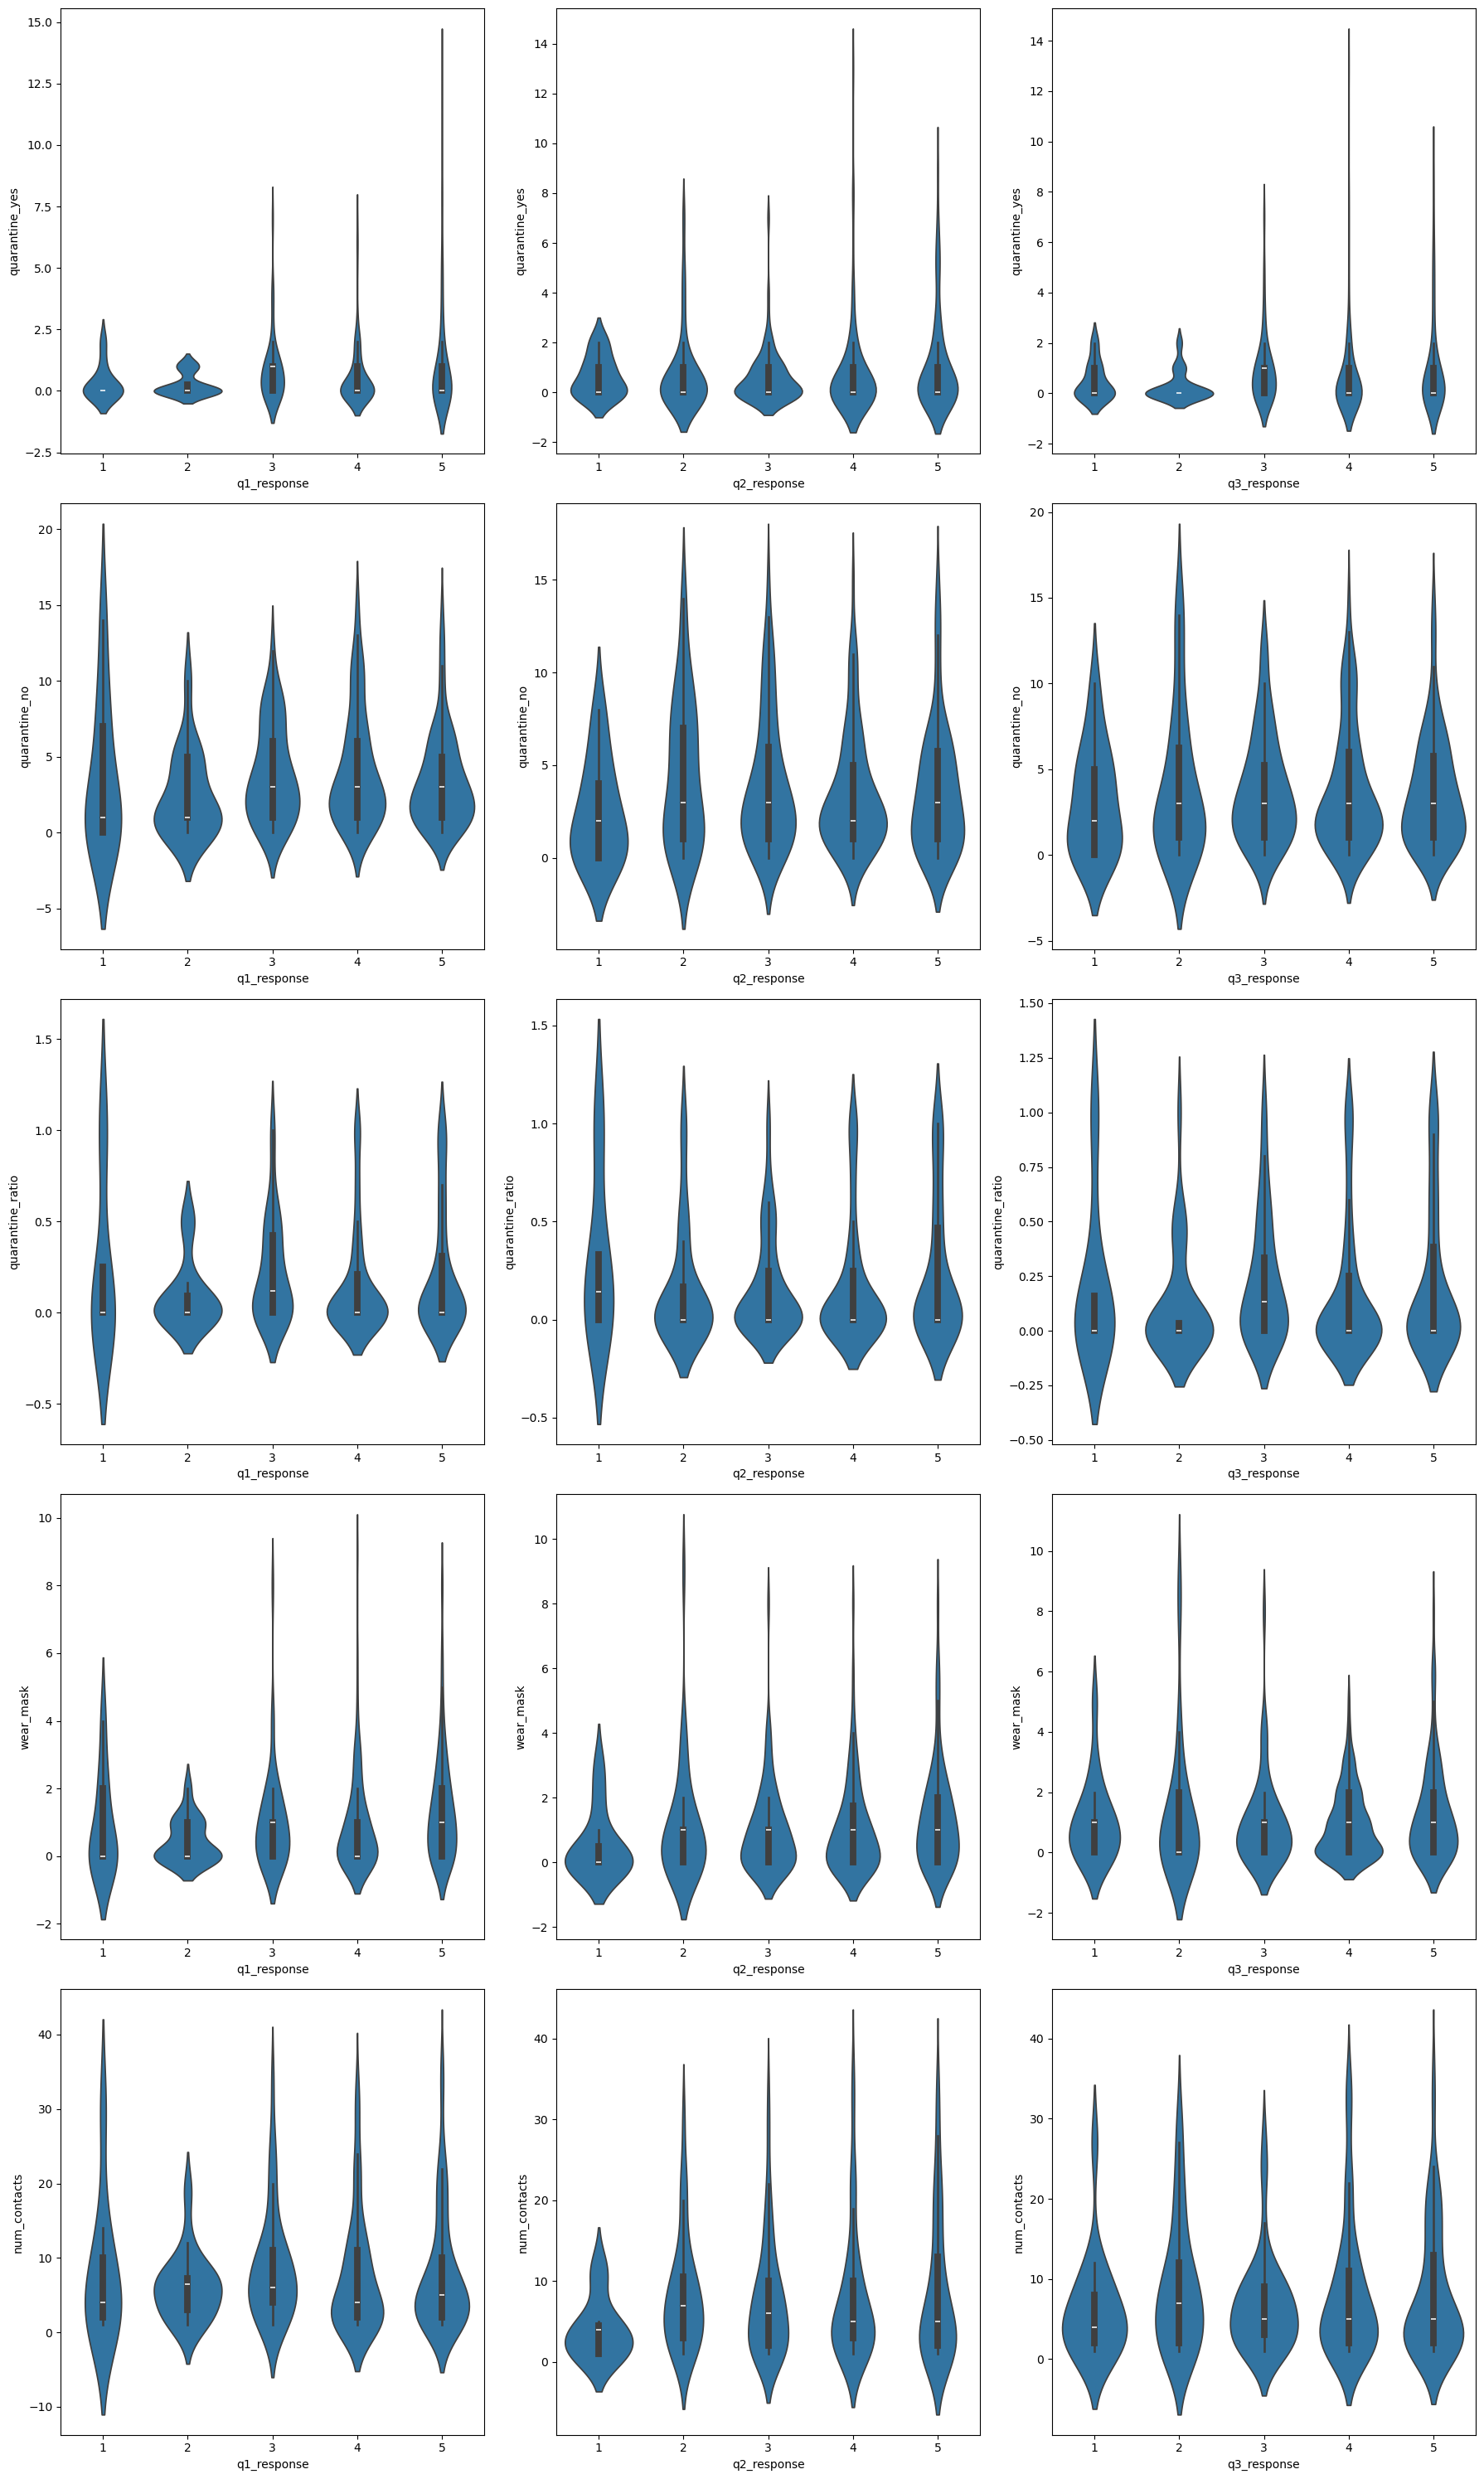

In [5]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=[18, 30])
for avar in action_vars:
    for dvar in demo_vars:    
        axis = axs[action_vars.index(avar), demo_vars.index(dvar)]
        sns.violinplot(x=dvar, y=avar, data=user_prefs, ax=axis)
        axis.set_xticks([0, 1, 2, 3, 4], ['1', '2', '3', '4', '5'])
fig.tight_layout()
plt.show()

In [6]:
# Significance level for Normality Check and Homogeneity of Variances Check. If those fail, then
# Kruskal-Wallis Test is used because is a a non-parametric alternative to one-way ANOVA and that 
# can be applied when the assumptions of ANOVA (normality and homogeneity of variances) are not met.
sig_level = 0.05

for avar in action_vars:
    for dvar in demo_vars:
        print(avar, 'AND', dvar)
        
        group1 = user_prefs[user_prefs[dvar] == 1][avar]
        group2 = user_prefs[user_prefs[dvar] == 2][avar]
        group3 = user_prefs[user_prefs[dvar] == 3][avar]
        group4 = user_prefs[user_prefs[dvar] == 4][avar]
        group5 = user_prefs[user_prefs[dvar] == 5][avar]

        # Normality check
        _, pnorm1 = stats.shapiro(group1)
        _, pnorm2 = stats.shapiro(group2)
        _, pnorm3 = stats.shapiro(group3)
        _, pnorm4 = stats.shapiro(group4)
        _, pnorm5 = stats.shapiro(group5)
        
        # Homogeneity of variances check
        _, phom = stats.levene(group1, group2, group3, group4, group5)

        anova_assumptions_valid = pnorm1 > sig_level and pnorm2 > sig_level and pnorm3 > sig_level and pnorm4 > sig_level and pnorm5 > sig_level and phom > sig_level
        if anova_assumptions_valid:
            f_statistic, p_value_fstat = stats.f_oneway(group1, group2, group3, group4, group5)    
            print(f'  Statistic for one-way ANOVA Test = {f_statistic:.2f} (p-value = {p_value_fstat:.2f})')
        else:
            h_statistic, p_value_hstat = stats.kruskal(group1, group2, group3, group4, group5)
            print(f'  Statistic for Kruskal-Wallis Test = {h_statistic:.2f} (p-value = {p_value_hstat:.2f})')

quarantine_yes AND q1_response
  Statistic for Kruskal-Wallis Test = 7.46 (p-value = 0.11)
quarantine_yes AND q2_response
  Statistic for Kruskal-Wallis Test = 2.44 (p-value = 0.66)
quarantine_yes AND q3_response
  Statistic for Kruskal-Wallis Test = 10.97 (p-value = 0.03)
quarantine_no AND q1_response
  Statistic for Kruskal-Wallis Test = 5.97 (p-value = 0.20)
quarantine_no AND q2_response
  Statistic for Kruskal-Wallis Test = 3.62 (p-value = 0.46)
quarantine_no AND q3_response
  Statistic for Kruskal-Wallis Test = 1.12 (p-value = 0.89)
quarantine_ratio AND q1_response
  Statistic for Kruskal-Wallis Test = nan (p-value = nan)
quarantine_ratio AND q2_response
  Statistic for Kruskal-Wallis Test = nan (p-value = nan)
quarantine_ratio AND q3_response
  Statistic for Kruskal-Wallis Test = nan (p-value = nan)
wear_mask AND q1_response
  Statistic for Kruskal-Wallis Test = 13.77 (p-value = 0.01)
wear_mask AND q2_response
  Statistic for Kruskal-Wallis Test = 6.55 (p-value = 0.16)
wear_mask 

In [7]:
corr = user_prefs.corr(method='kendall')
corr

,quarantine_yes,quarantine_no,quarantine_ratio,wear_mask,q1_response,q2_response,q3_response,num_contacts
quarantine_yes,1.000000,-0.090407,0.889022,0.144433,0.044068,0.030571,0.036627,0.153875
quarantine_no,-0.090407,1.000000,-0.321211,0.098045,-0.000483,-0.027932,0.011535,0.122205
quarantine_ratio,0.889022,-0.321211,1.000000,0.083481,0.013169,0.018466,0.011537,0.087091
wear_mask,0.144433,0.098045,0.083481,1.000000,0.162820,0.105763,0.071574,0.086395
q1_response,0.044068,-0.000483,0.013169,0.162820,1.000000,0.595367,0.475550,-0.014648
q2_response,0.030571,-0.027932,0.018466,0.105763,0.595367,1.000000,0.485052,-0.003223
q3_response,0.036627,0.011535,0.011537,0.071574,0.475550,0.485052,1.000000,0.002422
num_contacts,0.153875,0.122205,0.087091,0.086395,-0.014648,-0.003223,0.002422,1.000000


## Assortativity with node properties

In [8]:
# Assortativity calculation using the DescrStatsW from statsmodels.stats.weightstats
# and the p-value using bootstrapping
for attrib in attribs: 
    rho = calc_weighted_attrib_assortativity(G, attrib)
    pval = calc_weighted_attrib_assortativity_sig(G, attrib, rho, 10000)
    print(f'Assortativity value for {attrib} = {rho:.2f} (p-value = {pval:.2f})')

Assortativity value for quarantine_yes = 0.10 (p-value = 0.21)
Assortativity value for quarantine_no = 0.17 (p-value = 0.16)
Assortativity value for quarantine_ratio = 0.15 (p-value = 0.11)
Assortativity value for wear_mask = 0.23 (p-value = 0.07)
Assortativity value for num_contacts = 0.31 (p-value = 0.05)
Assortativity value for q1_response = 0.14 (p-value = 0.23)
Assortativity value for q2_response = 0.36 (p-value = 0.05)
Assortativity value for q3_response = 0.25 (p-value = 0.12)


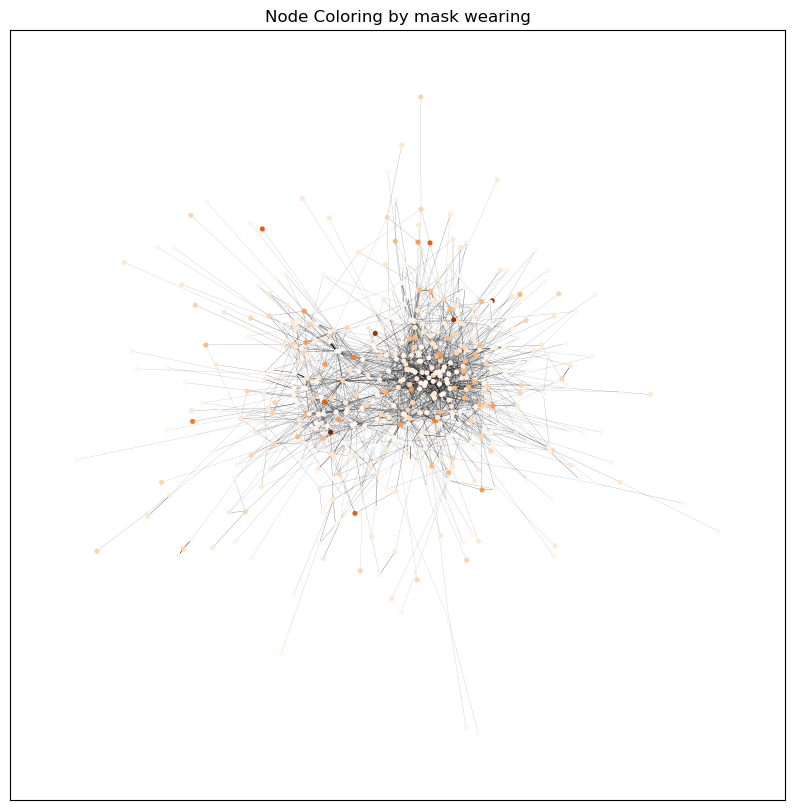

In [9]:
wm_dict = nx.get_node_attributes(G, 'wear_mask')
wm_attrib = [wm_dict[idx] for idx in wm_dict]
color_graph_by_attribute(G, Gpos, wm_attrib, 'Node Coloring by mask wearing', edge_weights)

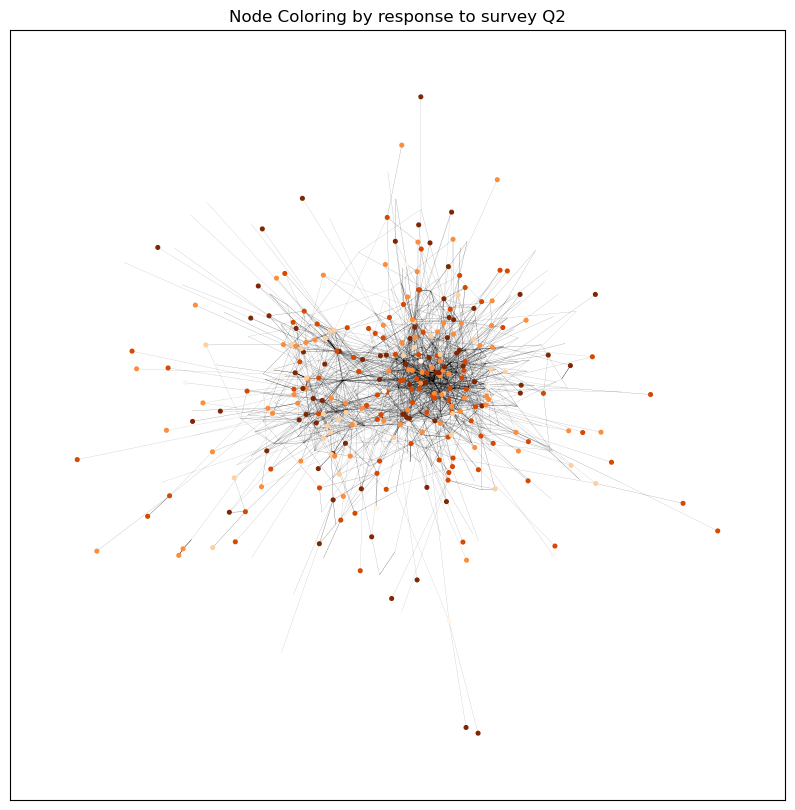

In [10]:
q2_dict = nx.get_node_attributes(G, 'q2_response')
q2_attrib = [q2_dict[idx] for idx in q2_dict]
color_graph_by_attribute(G, Gpos, q2_attrib, 'Node Coloring by response to survey Q2', edge_weights)